 ## net_sim_mp.ipynb

This notebook is a template to run multiprocess simulations using the ei_network class.  

The particular network being build and simulated under different variations is that from step1.ipynb part 2.


By `Sergio Verduzco`  
June 2018

In [1]:
# import the ei_network class and draculab
%cd ..
from ei_network import *
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/mp_net" + time.strftime("_%m-%d-%y.txt")

In [3]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [ ]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [3]:
%%capture capt2
# The cell above does input configuration, and this should capture it in 'capt2'
%history -l 1

In [ ]:
# Write the input configuration two cells above in the simulation log
f = open(log_file, mode='a')
f.write(capt2.stdout)
f.close()

In [3]:
class mp_net_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self):
        """ Set parameter values and build the networks. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            input_type : The 'input_config' method, called by 'run_all', will specify the inputs sent by I1 and I2 in each
                         network, by creating custop inp_pats and inp_funcs methods. The value of input_type[i] is used in
                         input_config to know which input type will be used in network 'i'.
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        
        """
        self.name = 'mp_net_runner_prototype'  # a name that describes the use
        self.n_procs = 2  # one per network is good
        self.n_nets = 2
        self.n_pres = [80]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.input_type = [0, 1]+[0]*(self.n_nets-2) # specifies the values input_config assigns to inp_pats and inp_funcs
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        #F = open("/media/z/DATA/pickles/mp_net_runner_prototype.pkl", 'rb')
        #dill_obj = dill.load(F)
        #self.nets = dill_obj.nets
        
        layers =  ['L', 'shrp','I1', 'I2']  # L is the layer, shrp is for the sharpen port, I1,I2 are the input layers
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('This is a prototype.')
            net.annotate('The base configuration is that for sds_n_sharp units in L.e')
        #----------------------------------
            L = net.layers['L']
            shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
        #----------------------------------
            L.annotate("Configuration of units in layer L.")
            L.set_param('e_pars', 'type', unit_types.sds_n_sharp)
            L.set_param('e_pars', 'slope_min', 6.)
            L.set_param('e_pars', 'slope_wid', .001)
            L.set_param('e_pars', 'thresh_min', .3)
            L.set_param('e_pars', 'thresh_wid', 0.001)
            L.set_param('e_pars', 'n_ports', 5)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.45, 0.45], 'slopes' : 4, 'threshs' : 0.2})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 2.)
            L.set_param('e_pars', 'tau_thr', .002)
            L.set_param('e_pars', 'rdc_port', 1)
            L.set_param('e_pars', 'thr_fix', 0.)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 4)
        #----------------------------------
            L.annotate("Adjusting size of e,i groups.")
            L.set_param('e_geom', 'rows', 8)
            L.set_param('e_geom', 'columns', 8)
            L.set_param('i_geom', 'rows', 4)
            L.set_param('i_geom', 'columns', 4)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.annotate("Compensating for the ratio of excitatory to inhibitory units.")
            #L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .1, 'high' : 0.1}})
            #L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .2, 'high' : 0.2}})
            #L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1., 'high' : -.1}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -.1, 'high' : -.1}})
            #L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -.5, 'high' : -0.5}})
        #----------------------------------
            L.annotate("Setting input parameters")
            L.set_param('x_geom', 'rows', 0) # no input units in layer L
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 1)
            L.set_param('ie_syn', 'inp_ports', 0)
        #----------------------------------
            L.annotate("Using Oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using BCM EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.bcm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            #L.set_param('ee_syn', 'omega', 2.)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./20.)
            L.set_param('e_pars', 'des_act', 0.4)
        #----------------------------------
            L.annotate("Using anti_cov_pre EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.anticov_pre)
            L.set_param('ei_syn', 'lrate', .02)
        #----------------------------------
            shrp.annotate("Leaving a single input unit in the layer")
            shrp.set_param('e_geom', 'rows', 0)
            shrp.set_param('i_geom', 'rows', 0)
            shrp.set_param('x_geom', 'rows', 1)
            shrp.set_param('x_geom', 'columns', 1)
        #----------------------------------
            shrp.annotate("Configuring sharpening unit")
            shrp.set_param('x_pars', 'function', lambda x : None)
            shrp.set_param('x_pars', 'init_val', 1.)
            shrp.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 8)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 8)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            shrp.set_param('n', 'w_track', 0)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
        #----------------------------------
        
        # Add interlayer connections
            net.add_connection(('shrp','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
         #----------------------------------
        
        # Configure interlayer connections
            net.set_param('shrpx_Le_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('shrpx_Le_conn', 'kernel', 1.)
            net.set_param('shrpx_Le_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('shrpx_Le_syn', 'init_w', 1.)
            net.set_param('shrpx_Le_syn', 'inp_ports', L.e_pars['sharpen_port'])

            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', 1.)
            net.set_param('I1x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', False)
            net.set_param('I1x_Le_syn', 'inp_ports', 2)

            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', 1.)
            net.set_param('I1x_Li_conn', 'weights', {'gaussian' : {'w_center': .2, 'sigma': 2.}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', False)

            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', 1.)
            net.set_param('I2x_Le_conn', 'weights', {'gaussian' : {'w_center': 1., 'sigma': .1}})
            net.set_param('I2x_Le_conn', 'edge_wrap', False)
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_syn', 'inp_ports', 3)

            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', 1.)
            net.set_param('I2x_Li_conn', 'weights', {'gaussian' : {'w_center': .2, 'sigma': 2.}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', False)
            
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network1
        n = 1
        the_net = self.nets[n]
        L = self.nets[n].layers['L']
        I1 = self.nets[n].layers['I1']
        I2 = self.nets[n].layers['I2']
        L.annotate("using sigmoidal units")
        L.set_param('e_pars', 'type', unit_types.sigmoidal)
        L.set_param('e_pars', 'slope_min', 2.)
        L.set_param('e_pars', 'n_ports', 1)
        L.set_param('ee_conn', 'weights',{'uniform' : {'low': .05, 'high' : 0.1}})
        L.set_param('ei_conn', 'weights',{'uniform' : {'low': .1, 'high' : 0.2}})
        L.set_param('ie_conn', 'weights',{'uniform' : {'low': -.4, 'high' : -.4}})
        L.set_param('ii_conn', 'weights',{'uniform' : {'low': -.4, 'high' : -0.4}})
        L.annotate("Using sq_hebbsnorm EE synapses")
        L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
        L.set_param('ee_syn', 'lrate', 1./100.)
        L.set_param('ee_syn', 'omega', 1.)
        L.annotate("Using BCM input synapses")
        L.set_param('xe_syn', 'type', synapse_types.bcm)
        L.set_param('xe_syn', 'lrate', 1./100.)
        L.set_param('xi_syn', 'type', synapse_types.bcm)
        L.set_param('xi_syn', 'lrate', 1./100.)
        the_net.set_param('I1x_Le_conn', 'weights', {'gaussian' : {'w_center': .5, 'sigma': .2}})
        the_net.set_param('I1x_Li_conn', 'weights', {'gaussian' : {'w_center': .4, 'sigma': .2}})
        the_net.set_param('I2x_Le_conn', 'weights', {'gaussian' : {'w_center': .5, 'sigma': .2}})
        the_net.set_param('I2x_Li_conn', 'weights', {'gaussian' : {'w_center': .4, 'sigma': .2}})
                                                                  
        # Building the networks
        for net in self.nets:
            net.build()
    
    def inp_pat1(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I1
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def inp_pat2(self, pres, rows, columns, net_id, n_pat, port=0, random=True):
        # A function to create input patterns for I2
        if random:
            idx = np.random.randint(n_pat)
        else:
            idx = pres % n_pat
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat)) for x in range(n_pat)], idx)

    def make_I1_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat1(pres, rows, columns, net_id, n_pat, random=rnd) 
    
    def make_I2_inp(self, n_pat, rnd):
        return lambda pres, rows, columns, net_id: self.inp_pat2(pres, rows, columns, net_id, n_pat, random=rnd)

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def input_config(self):
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            #shrp = net.layers['shrp']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units
            #pats1 = [] # here we'll store id's for the patterns presented by inp_pat1
            #pats2 = [] # here we'll store id's for the patterns presented by inp_pat2
            if self.input_type[idx] == 0:  # for sharpening units
                shrp_inp_pat = lambda p, r, c, n : (1., 1)
                inp_pat_dic = {'I1' : self.make_I1_inp(n_pat1, True), 
                               'I2' : self.make_I2_inp(n_pat2, True), 
                               'shrp' : shrp_inp_pat}
                inp_fun_dic = {'shrp' : self.set_shrp_fun }
            elif self.input_type[idx] == 1: # for non-sharpening units
                inp_pat_dic = {'I1' : self.make_I1_inp(n_pat1, True), 
                               'I2' : self.make_I2_inp(n_pat2, True) } 
                inp_fun_dic = {}
            else:
                raise ValueError('Invalid input type for network ' + str(idx))
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def run_net(self, net_num):
        print('Running network %d' % (net_num))
        return self.nets[net_num].run(self.n_pres[net_num], self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        
    def run_all(self, save=False, log=False):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        self.nets = pool.map(self.run_net, range(self.n_nets))
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        if save:
            for net in self.nets:
                net.history.append('ei_net object being saved in container mp_ei_runner object ' + self.name)
            F = open(self.name+'.pkl', 'wb')
            dill.dump(self, F)
            F.close()
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
                                

In [4]:
# Simulating
mp_net_obj = mp_net_runner()
mp_net_obj.run_all(save=False, log=False)

Building layer I1
Building layer shrp
Building layer L
Building layer I2
Creating shrpx_Le connection
Creating I1x_Le connection


/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


Creating I1x_Li connection
Creating I2x_Le connection
Creating I2x_Li connection
Building layer I1
Building layer shrp
Building layer L
Building layer I2
Creating shrpx_Le connection
Creating I1x_Le connection
Creating I1x_Li connection
Creating I2x_Le connection
Creating I2x_Li connection
Starting 2 processes, 2 networks
Running network 0
Starting presentation 0 at network 0
Running network 1
Starting presentation 0 at network 1
Presentation 0 took 8.655142068862915 seconds  at network 1
Starting presentation 1 at network 1
Presentation 0 took 14.801593780517578 seconds  at network 0
Starting presentation 1 at network 0
Presentation 1 took 8.433085203170776 seconds  at network 1
Starting presentation 2 at network 1
Presentation 2 took 8.629545450210571 seconds  at network 1
Starting presentation 3 at network 1
Presentation 1 took 14.564805269241333 seconds  at network 0
Starting presentation 2 at network 0
Presentation 3 took 8.508955717086792 seconds  at network 1
Starting presentati

Starting presentation 50 at network 1
Presentation 29 took 14.23505163192749 seconds  at network 0
Starting presentation 30 at network 0
Presentation 50 took 8.719082593917847 seconds  at network 1
Starting presentation 51 at network 1
Presentation 51 took 8.847114562988281 seconds  at network 1
Starting presentation 52 at network 1
Presentation 30 took 14.367265939712524 seconds  at network 0
Starting presentation 31 at network 0
Presentation 52 took 8.74830961227417 seconds  at network 1
Starting presentation 53 at network 1
Presentation 53 took 8.767879247665405 seconds  at network 1
Starting presentation 54 at network 1
Presentation 31 took 14.52030873298645 seconds  at network 0
Starting presentation 32 at network 0
Presentation 54 took 8.950855731964111 seconds  at network 1
Starting presentation 55 at network 1
Presentation 32 took 14.508419513702393 seconds  at network 0
Starting presentation 33 at network 0
Presentation 55 took 9.14062237739563 seconds  at network 1
Starting p

****** Processing finished after 1216.6384408473969 seconds ******


In [5]:
mp_net_obj.nets[2].inp_hist

{'I1': [0, 6], 'I2': [7, 6], 'shrp': [1, 1]}

norm of output matrix: 39.479597
norm of input matrix: 43.979793
norm of difference between matrices: 37.179620


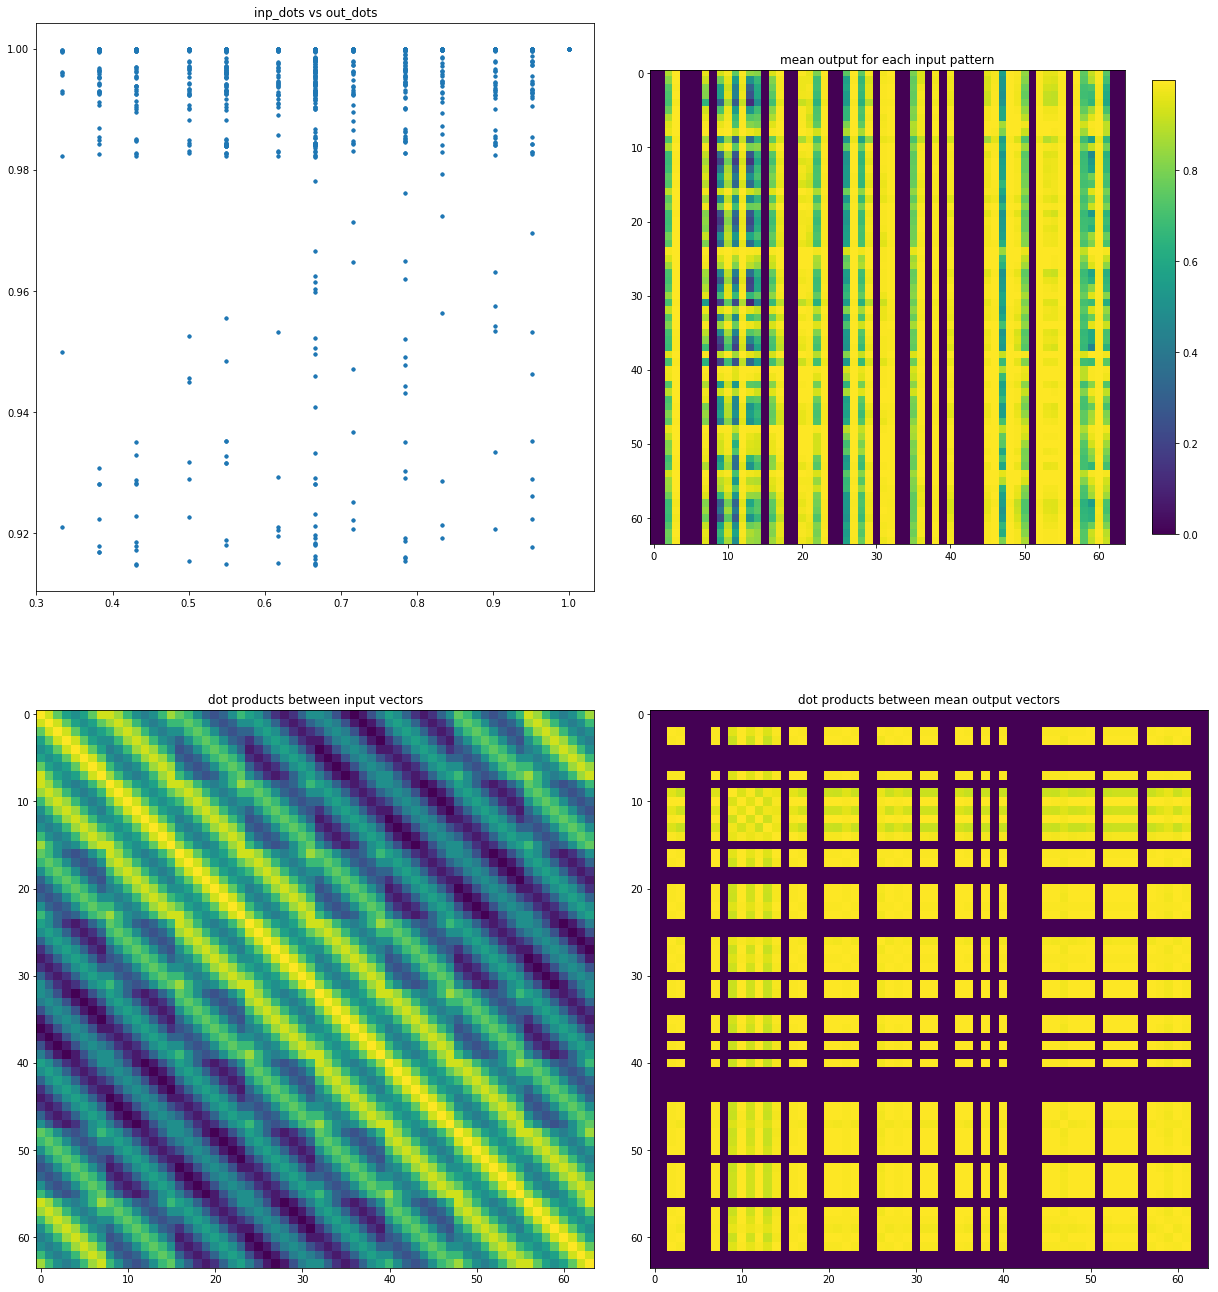

In [6]:
# Simulation analysis
net_num = 1
ei_net = mp_net_obj.nets[net_num]
pats1 = ei_net.inp_hist['I1']
pats2 = ei_net.inp_hist['I2']
n_pat1 = ei_net.layers['I1'].n['x']
n_pat2 = ei_net.layers['I2'].n['x']
pres_time = mp_net_obj.pres_t[net_num]
n_pres = mp_net_obj.n_pres[net_num]
L = ei_net.layers['L']
inp_pat1 = mp_net_obj.make_I1_inp(n_pat1, False)
inp_pat2 = mp_net_obj.make_I2_inp(n_pat2, False)

## For each input presentation obtain the activity vector from layer L
ppat = int(round(pres_time/ei_net.net_params['min_delay'])) # number of data points per input pattern
pt = int(round((pres_time-0.2)/ei_net.net_params['min_delay'])) # data point where the vector will come from
e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
for pres in range(n_pres):
    for e_idx, idx in enumerate(L.e):
        e_pats[e_idx, pres] = ei_net.all_activs[idx, pres*ppat + pt]

# The ID of the input comes from the id's in pats1 and pats2, placed by inp_pat1 and inp_pat2 respectively.
pats = np.zeros(n_pat1*n_pat2)  # pats[n] is the number of times the pattern with ID 'n' appeared
n_pats = len(pats)
pres_pat = np.zeros(n_pres)  # pres_pat[n] is the ID of the pattern in presentation 'n'
for p in range(n_pres):
    p_id = n_pat2*pats1[p] + pats2[p] # the pattern ID 'flattens' all possible pairs of values
    pats[p_id] += 1
    pres_pat[p] = p_id
    
# plot the array of activity patterns
#%matplotlib inline
#ex_fig = plt.figure(figsize=(20,20))
#plt.imshow(e_pats)

# get the mean of output patterns corresponding to the same inputs
mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
for pres in range(n_pres):
    mean_out[:,int(pres_pat[pres])] += e_pats[:,pres]
    
for pat in range(n_pats):
    if pats[pat] > 1:
        mean_out[:, pat] = mean_out[:, pat]/ pats[pat]
        
# Obtain the angles between any two pairs of input patterns
# get all input patterns
all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
for p1 in range(n_pat1):
    for p2 in range(n_pat2):
        (all_inps[p1*n_pat2+p2, :n_pat1], _) = inp_pat1(p1, 1, 1, net_num)
        (all_inps[p1*n_pat2+p2, n_pat1:], _) = inp_pat2(p2, 1, 1, net_num)
        

# get matrices with dot products between pairs of patterns
inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
inp_norm2 = inp_norm*inp_norm
inp_dots = np.zeros((n_pats, n_pats))
out_dots = np.zeros((n_pats, n_pats))
for p1 in range(n_pats):
    for p2 in range(n_pats):
        inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
        if pats[p1] > 0 and pats[p2] > 0: # if the two input patterns were presented
                #pres_idx1 = np.argmin(abs(pres_pat - p1))  # index of presentation where you showed pattern 1
                #pres_idx2 = np.argmin(abs(pres_pat - p2))  # index of presentation where you showed pattern 2
                #vec1 = e_pats[:,pres_idx1]  # first input vector
                #vec2 = e_pats[:,pres_idx2]  # second input vector
                vec1 = mean_out[:,p1]
                vec2 = mean_out[:,p2]
                norm1 = np.linalg.norm(vec1)
                norm2 = np.linalg.norm(vec2)
                out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)

                
# compare the angles between input patterns with the angles between output patterns
absissae = []
ordinates = []
for row in range(n_pats):
    for column in range(n_pats):
        if out_dots[row,column] > 0:
            absissae.append(inp_dots[row,column])
            ordinates.append(out_dots[row,column])
            
#plot the results of the analysis
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(21, 23))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

im0 = axes[0,0].plot(absissae, ordinates, '.')
axes[0,0].set_title('inp_dots vs out_dots')
im1 = axes[0,1].imshow(mean_out)
axes[0,1].set_title('mean output for each input pattern')
fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
im2 = axes[1,0].imshow(inp_dots)
axes[1,0].set_title('dot products between input vectors')
im3 = axes[1,1].imshow(out_dots)
axes[1,1].set_title('dot products between mean output vectors')
#fig.colorbar(im3,fraction=0.1,shrink=0.8)

    
# A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
print("norm of output matrix: %f" % (np.linalg.norm(out_dots)))
print("norm of input matrix: %f" % (np.linalg.norm(inp_dots)))
print("norm of difference between matrices: %f" % (diff_norm))

In [ ]:
%%capture capt3
# The cell above does input configuration, and this should capture it in 'capt2'
%history -l 1

In [ ]:
# Write the analysis code two cells above in the simulation log
f = open(log_file, mode='a')
f.write(capt3.stdout)
f.close()

In [ ]:
# plot the array of activity patterns, or difference matrix
%matplotlib inline
ex_fig = plt.figure(figsize=(20,20))
#plt.imshow(e_pats[:,:100])
plt.imshow(inp_dots-out_dots)
plt.colorbar()

In [ ]:
%matplotlib inline
ei_net.basic_plot('L')

In [ ]:
%matplotlib inline
ei_net.basic_plot('shrp')

In [ ]:
ei_net.double_anim(L.e+I1.x+I2.x, slider=True, interv=50, nbins=20, thr=0.7, pdf=True)

In [ ]:
# Plot the highest excitatory unit activities
%matplotlib inline
n_top = 2  # how many units to plot
top_pop = np.array(L.e)  # population to visualize
top_units = ei_net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = ei_net.all_activs[top_pop[top_units]].transpose()
plt.plot(ei_net.all_times, top_acts)
plt.show()

In [ ]:
# Plot the lowest excitatory unit activities
n_bottom = 10  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = ei_net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = ei_net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(ei_net.all_times, bottom_acts)
plt.show()

In [ ]:
# Annotations and log
ei_net.annotate("This run was meant to set the best-possible middle-layer input representation, using ", make_history=False)
ei_net.annotate("preset criss-cross connectivity and the most complex unit available.  ", make_history=False)
ei_net.annotate("This is the first time the analysis of the output is done, and to ensure that. ", make_history=False)
ei_net.annotate("all possible input pattern were presented, and the network was not changing anymore, ", make_history=False)
ei_net.annotate("the simulation consisted of 1000 pattern presentations, taking roughly 15000 seconds in breaker. ", make_history=False)
ei_net.annotate("The analysis shows excellent representation. Also, those Oja synapses never did", make_history=False)
ei_net.annotate("stop growing.", make_history=False)
ei_net.log(name=log_file,params=True)